# New Beginning

In [2]:
import sys
import tensorflow as tf
import numpy as np
from keras import layers
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Reshape, Add, Dense, Lambda ,Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

from keras import backend
from keras.engine.topology import Layer
import glob

In [2]:
class CustomLayer(Layer):
    def __init__(self, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', shape=input_shape[1:], initializer='uniform', trainable=True)
        super(CustomLayer, self).build(input_shape)
        
    def call(self, x):
        y = x*self.kernel
        return y
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [3]:
def res_unit(X, n_filters, kernel_size):
    X_shortcut = X
    
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(n_filters, kernel_size, padding="same")(X)
    
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(n_filters, kernel_size, padding="same")(X)
    
    X = Add()([X,X_shortcut])
    
    return X

In [4]:
def res_start(X, n_filters, kernel_size):
    X = Conv2D(n_filters, kernel_size, padding = "same")(X)
    return X

In [5]:
def res_end(X, n_filters, kernel_size):
    X = Conv2D(n_filters, kernel_size, padding = "same")(X)
    return X

In [6]:
def res_net(input_shape, n_res_units, n_filters, kernel_size):
    X_input = Input(input_shape)
    X = res_start(X_input, n_filters, kernel_size)
    
    for i in range(n_res_units):
        X = res_unit(X, n_filters, kernel_size)
    
    output = res_end(X, 2, kernel_size)
#     output = CustomLayer()([output])
#     output = Activation('tanh')(output)
    
    model = Model(X_input, output, name='res_net')
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics= ['accuracy'])
    return model

In [7]:
def st_resnet(input_shape, n_res_units, n_filters, kernel_size, mini, maxi):
    
    closeness_model = res_net((input_shape[0],input_shape[1], input_shape[2]//3), n_res_units, n_filters, kernel_size)
    period_model = res_net((input_shape[0],input_shape[1], input_shape[2]//3), n_res_units, n_filters, kernel_size)
    trend_model =  res_net((input_shape[0],input_shape[1], input_shape[2]//3), n_res_units, n_filters, kernel_size)
        
    fused_output = Add()([CustomLayer()([closeness_model.output]), CustomLayer()([period_model.output]), CustomLayer()([trend_model.output])])
    
    output = Activation('tanh')(fused_output)
    
#     output1 = output[:,:,:,:,0]
#     output2 = output[:,:,:,:,1]
    
#     o_shape = output.shape
#     print(o_shape)
    
# #     output1 = tf.reshape(output1,[1, o_shape[2]*o_shape[3]])
# #     output2 = tf.reshape(output2,[1, o_shape[2]*o_shape[3]])

# #     output = Lambda(lambda x: tf.reshape(x,[2, o_shape[2]*o_shape[3]]))(output)
    
#     output = Reshape((2, o_shape[2]*o_shape[3]))(output)
    
#     print(output.shape)
        
#     def scale(x):
#         return x*(scaler.data_range_) + scaler.data_min_

    
#     output = Lambda(scale)(output)
    
# #     output = Lambda(lambda x: tf.reshape(x,[o_shape[2],o_shape[3],2]))(output)
    
#     output = Reshape((o_shape[2],o_shape[3],2))(output)
    
#     print(output.shape)
    
    #Scaling tanH output to training data's distribution
    
    def scale(x):
        return x*(maxi-mini) + mini
    
    def scale_range(x):
        return ((x+1)*(maxi-mini)/2)+mini
    
#     print(maxi, mini)
    
    output = Lambda(scale_range)(output)
    
    st_resnet_model = Model([closeness_model.input, period_model.input, trend_model.input], output, name = "st_resnet")
    return st_resnet_model

In [8]:
files = []
for filename in glob.glob("../preprocessing/right_block/start/*.txt"):
    files.append(filename)
    
files = sorted(files)

starts = []
for filename in files:
    starts.append(np.loadtxt(filename, delimiter=","))

start_array = np.array(starts)
start_array = start_array.reshape(start_array.shape+tuple([1]))

In [9]:
files = []
for filename in glob.glob("../preprocessing/right_block/end/*.txt"):
    files.append(filename)
    
files = sorted(files)

ends = []
for filename in files:
    ends.append(np.loadtxt(filename, delimiter=","))

end_array = np.array(ends)
end_array = end_array.reshape(end_array.shape+tuple([1]))

In [10]:
data = np.concatenate((start_array, end_array), axis=3)

In [11]:
def get_training_data(data, sequence_length, trend_gap, period_gap, closeness_gap):
    
    training_data_x = []
    
    training_data_y = []
    di = 0
    ni = 0
    ri = 0
    while((di+(trend_gap*sequence_length)+(period_gap*sequence_length) + (closeness_gap*sequence_length))<len(data)):
#         print("condition: "+str(di+(trend_gap*sequence_length)+(period_gap*sequence_length) + (closeness_gap*sequence_length)))
        distant = None
        near = None
        recent = None
        di_old = di
        for i in range(sequence_length):
#             print("di: ", di)
            if(distant is None):
                distant = data[di]
            else:
                distant = np.concatenate((distant, data[di]), axis = 2)
#             distant.append(data[di])
            di+=trend_gap
            
        ni = di-trend_gap+period_gap
        for i in range(sequence_length):
#             print("ni: ", ni)
            if(near is None):
                near = data[ni]
            else:
                near = np.concatenate((near, data[ni]), axis = 2)
#             near.append(data[ni])
            ni+=period_gap
            
        ri = ni-period_gap + closeness_gap
        for i in range(sequence_length):
#             print("ri: ", ri)
            
            if(recent is None):
                recent = data[di]
            else:
                recent = np.concatenate((recent, data[ri]), axis = 2) 
#             recent.append(data[di])
            ri+=closeness_gap
            
#         distant = np.array(distant)
#         print(distant.shape)
        
        training_point = np.concatenate((distant,near,recent), axis=2)
#         print(training_point.shape)
        shape = training_point.shape
#         training_point = training_point.reshape((shape[1], shape[2], shape[0]*shape[3]))
#         print(training_point.shape)
        training_data_x.append(training_point)
        training_data_y.append(data[ri])
        di = di_old + 1
        
    return np.array(training_data_x), np.array(training_data_y)

In [12]:
sequence_length = 4

X_t, Y_t = get_training_data(data, sequence_length, 4, 2, 1)
x_closeness = X_t[:,:,:,:sequence_length*2]
x_period = X_t[:,:,:,sequence_length*2:2*sequence_length*2]
x_trend = X_t[:,:,:,2*sequence_length*2:]

model = st_resnet((32,32, 6*sequence_length), 12, 64, (3,3),np.min(Y_t, axis=0), np.max(Y_t, axis=0) )
model.compile(optimizer='adam', loss='mean_squared_error', metrics= ['accuracy'])

In [13]:
model_history = model.fit([x_closeness,x_period,x_trend], Y_t, epochs = 1, batch_size = 32, verbose = 2)


Epoch 1/1
 - 513s - loss: 1741.0267 - accuracy: 0.4662


In [14]:
p = model.predict([np.array([X_t[5,:,:,:sequence_length*2]]), np.array([X_t[5,:,:,sequence_length*2:2*sequence_length*2]]),np.array([X_t[5,:,:,2*sequence_length*2:]])])

In [15]:
model_history.history

{'loss': [1741.0266541363442], 'accuracy': [0.46624705]}

In [16]:
q = p.reshape((32,32,2))

In [17]:
q_in = q[:,:,0]
q_out = q[:,:,1]

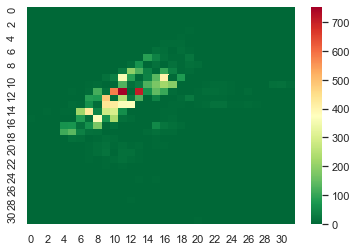

In [18]:
import seaborn as sns; 
sns.set()

ax = sns.heatmap(q_in, cmap = "RdYlGn_r")
# ax = sns.heatmap(q_out, cmap = "RdYlGn_r")

In [19]:
y_5_in = Y_t[5,:,:,0]
y_5_out = Y_t[5,:,:,1]

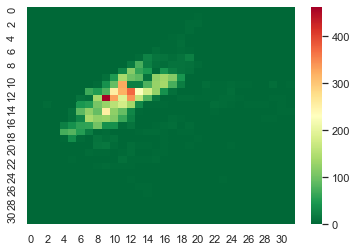

In [20]:
sns.set()

# ax = sns.heatmap(y_5_in, cmap = "RdYlGn_r")
ax = sns.heatmap(y_5_out, cmap = "RdYlGn_r")

In [21]:
x = np.loadtxt("..\preprocessing\\right_block\start\\20090101183000.txt", delimiter=",")

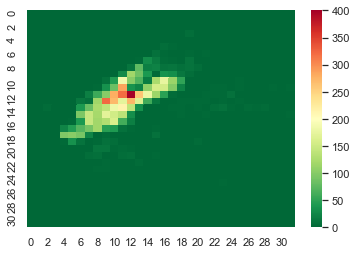

In [29]:
ax = sns.heatmap(y_5_in, cmap = "RdYlGn_r")

In [33]:
res = model.evaluate([x_closeness,x_period,x_trend], Y_t)

1460/1460 [==============================] - 140s 96ms/step


In [26]:
model.metrics_names

['loss', 'accuracy']

In [32]:
np.sqrt(1035*32/1460)

4.762870091326165

In [35]:
q.shape

(32, 32, 2)

In [37]:
Y_t[5].shape

(32, 32, 2)

In [40]:
(Y_t[5] - q).shape

(32, 32, 2)

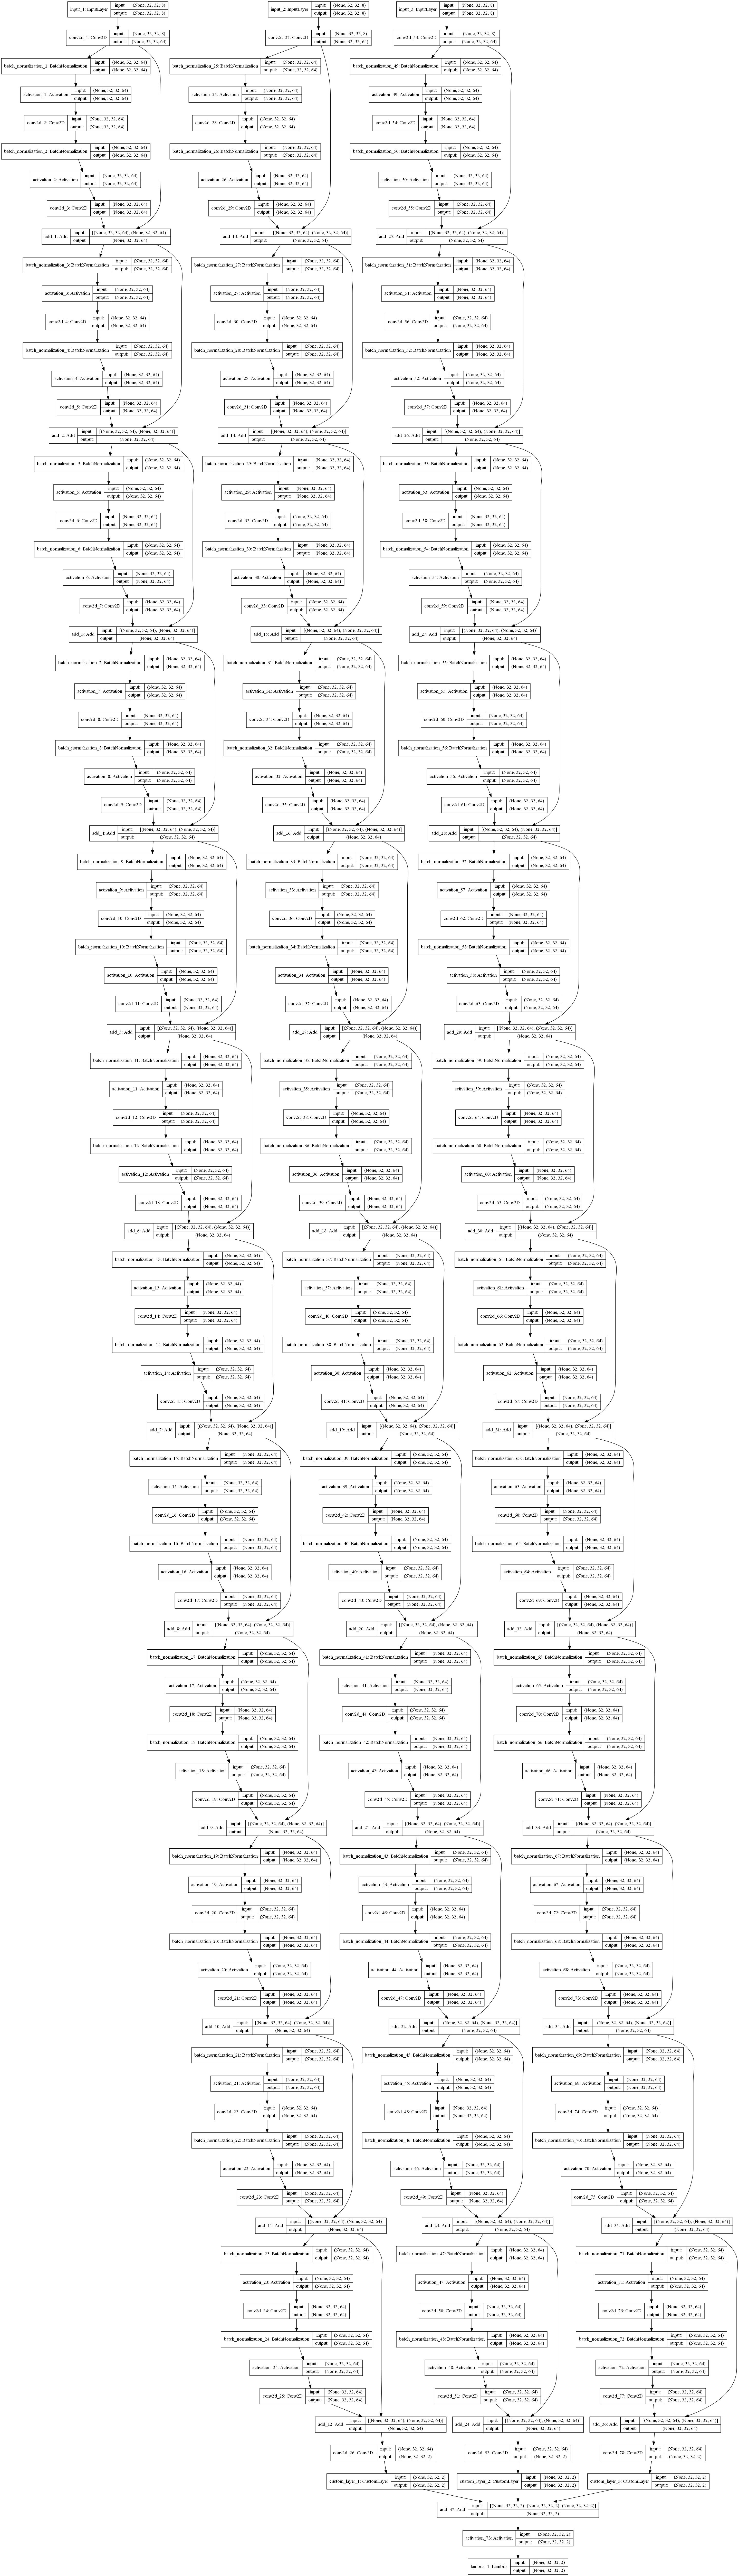

In [41]:
plot_model(model, show_shapes=True)